In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
sns.set_context('paper', font_scale=2.2)
sns.set_style('ticks')

We begin by importing the python piece of my image analyis pipeline.

In [6]:
import range_expansion_experiment.image_analysis as rei

I have a bunch of images in the folder below; we are going to analyze them.

In [7]:
base_folder = './2016_01_15/'

In [14]:
experiment = rei.Publication_Experiment(base_folder, cache=True, title='sweeps')

In [15]:
complete_images = experiment.complete_radii
print complete_images
for image_num in complete_images:
    cur_imset = experiment.experiment.image_set_list[image_num]
    cur_imset.finish_setup()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


Each "image_set" objects consists of many different relevant images. For example, we can overlay domains that were labeled with the actual experimental image.

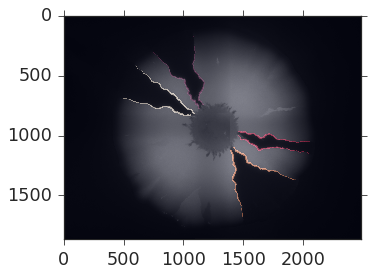

In [30]:
plt.imshow(cur_imset.image[0], cmap=plt.cm.binary_r)
plt.imshow(cur_imset.labeled_domains, alpha=0.5)

Let's determine how the angular width of these domains changes with colony radius.

In [31]:
mean_data_all_sweeps = {}

# How does domain angular width change with colony radius?

We begin by binning the domains consistently in radius allowing for easy comparison across experiments (image-sets).

In [32]:
radius_start = 0
radius_end = 15

# Let's have 40 bins per mm
bins_per_mm = 40

num_bins = np.int((radius_end-radius_start)*bins_per_mm)

length_cutoff = 0.

We're going to focus on the black strain sweeping through others right now.

In [33]:
black_images = []
for index in complete_images:
    cur_imset = experiment.experiment.image_set_list[index]
    if 'black' in cur_imset.image_name:
        black_images.append(index)

In [34]:
black_images

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

We create a dataframe containing information about all domains across all experiments.

In [35]:
combined_df = experiment.experiment.get_domain_dfs(black_images, radius_start=radius_start, radius_end=radius_end,
                                                   num_bins=num_bins)

2016_01_15_black_sweep_01_alpha-0019.ome.tif
2016_01_15_black_sweep_02_alpha-0021.ome.tif
2016_01_15_black_sweep_03_alpha-0023.ome.tif
2016_01_15_black_sweep_04_beta-0025.ome.tif
2016_01_15_black_sweep_05_beta-0027.ome.tif
2016_01_15_black_sweep_06_beta-0029.ome.tif
2016_01_15_black_sweep_07_gamma-0031.ome.tif
2016_01_15_black_sweep_08_gamma-0033.ome.tif
2016_01_15_black_sweep_09_gamma-0035.ome.tif
2016_01_15_black_sweep_10_gamma-0036.ome.tif


In [36]:
combined_df.head(5)

,radius_scaled,delta_theta,initial_radius,max_radius,domain_length,theta_o,theta_minus_theta_o,domain_label,log_R_div_Ro,imset_index
8,2.691987,0.169210,2.691987,10.304674,7.612688,0.16921,0.000000,1.0,0.000000,0
9,2.717028,0.163061,2.691987,10.304674,7.612688,0.16921,-0.006150,1.0,0.009259,0
10,2.742070,0.162620,2.691987,10.304674,7.612688,0.16921,-0.006591,1.0,0.018434,0
11,2.767112,0.162426,2.691987,10.304674,7.612688,0.16921,-0.006785,1.0,0.027525,0
12,2.792154,0.167981,2.691987,10.304674,7.612688,0.16921,-0.001230,1.0,0.036534,0


How many domains do we have?

In [39]:
# We're not going to use a length cutoff today.
#combined_df = combined_df.loc[combined_df['domain_length'] >= length_cutoff, :]

In [40]:
count = 0
for name in combined_df.groupby(['imset_index', 'domain_label']):
    count += 1

In [41]:
count

53

Let's plot info about our domains.

In [42]:
plt.rc('text', usetex=True)

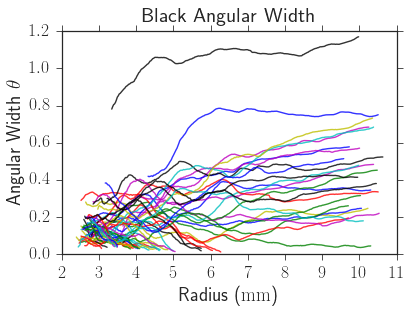

In [52]:
for name, cur_data in combined_df.groupby(['imset_index', 'domain_label']):
    plt.plot(cur_data['radius_scaled'], cur_data['delta_theta'], alpha=0.8)
    
plt.xlabel(r'Radius ($\mathrm{mm}$)')
plt.ylabel(r'Angular Width $\theta$')
plt.title('Black Angular Width', y=1.02)

Many domains die out quickly. Interesting. We are usually interested in domain width vs *logarithmic* radius, however. Plotting angular width vs. $\log(R/R_0)$, where $R_0$ is the initial radius where we begin tracking domains,

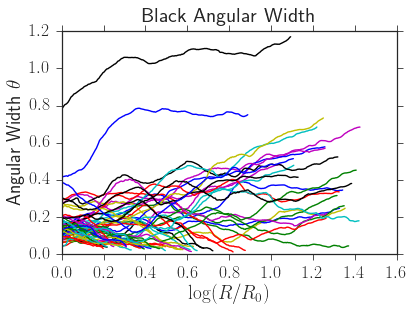

In [55]:
for name, cur_data in combined_df.groupby(['imset_index', 'domain_label']):
    plt.plot(cur_data.log_R_div_Ro, cur_data['delta_theta'])

plt.ylabel(r'Angular Width $\theta$')
plt.xlabel(r'$\log(R/R_0)$')

plt.title('Black Angular Width', y=1.02)

Do the sectors on average grow or shrink? We plot their growth over time relative to their initial angular width $\theta_0$.

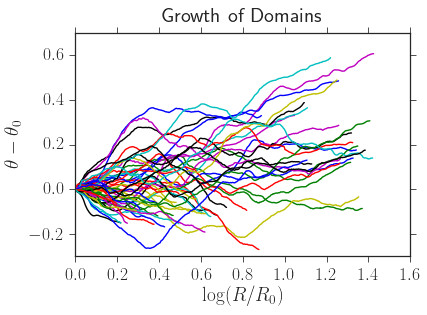

In [84]:
for name, cur_data in combined_df.groupby(['imset_index', 'domain_label']):
    plt.plot(cur_data.log_R_div_Ro, cur_data['theta_minus_theta_o'])
    
plt.xlabel(r'$\log(R/R_0)$')
plt.ylabel(r'$\theta - \theta_0$')
plt.title('Growth of Domains', y=1.03)

It looks like, on average, the black domains become larger. This is consistent with my experimental setup (the black strains of *E. coli* grow faster). Let's determine the average growth of a domain vs. logarithmic radius (something we can predict theoretically).

In [63]:
import scipy as sp

In [64]:
import pandas as pd

In [65]:
log_r_div_Ro_bins = np.linspace(0, 1.4, 150) # Choose the highest number of bins where traces still appear continuous

log_r_midbins = (log_r_div_Ro_bins[:-1] + log_r_div_Ro_bins[1:])/2.

# Average each trace individually first to avoid problems...
cut = pd.cut(combined_df.log_R_div_Ro, log_r_div_Ro_bins, labels=log_r_midbins)
averaged_traces = combined_df.groupby(['imset_index', 'domain_label', cut]).agg(np.mean)

averaged_traces.rename(columns={'log_R_div_Ro':'log_R_div_Ro_mean'}, inplace=True)

Plotting the average over the traces,

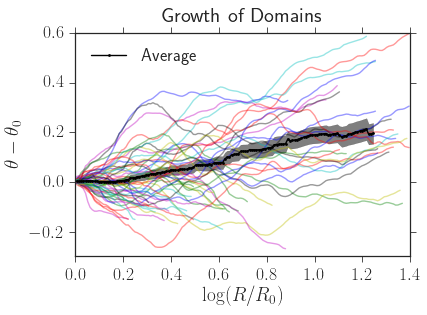

In [83]:
for name, cur_data in averaged_traces.reset_index().groupby(['imset_index', 'domain_label']):
    plt.plot(cur_data.log_R_div_Ro, cur_data['theta_minus_theta_o'], ls='-', alpha=0.4, label='')

    
no_nan_averaged = averaged_traces.dropna()
mean_data = no_nan_averaged.reset_index().groupby('log_R_div_Ro').agg([np.mean, sp.stats.sem]).reset_index()

# Drop data above a given log radius as it becomes unreliable...not enough data points
mean_data = mean_data.loc[mean_data['log_R_div_Ro'] <= 1.25, :]

x = mean_data['log_R_div_Ro'].values
y = mean_data['theta_minus_theta_o', 'mean'].values
yerr = mean_data['theta_minus_theta_o', 'sem'].values

plt.plot(x, y, ls='-', marker='.', color='black', label='Average')
# Plot the error
plt.fill_between(x, y - yerr, y + yerr, alpha=0.5, color='black')

plt.legend(loc='best')

plt.xlabel(r'$\log(R/R_0)$')
plt.ylabel(r'$\theta - \theta_0$')
plt.title('Growth of Domains', y=1.03)

So indeed, it looks like the black domains grow larger vs. time!

# Fitting the growth of black domains via bootstrapping

I want to determine the slope of the average growth of the black domains vs. logarithmic radius. I also want to know the error in our measurement of the slope. To solve this problem, I bootstrap from all of the different domains and fit the resulting average slope.

In [85]:
def bootstrap_slope(input_gb, radius_bins, function_to_use, bin_name, column_name, num_times=10**5):
    data_list = []
    
    radius_index= pd.Index(radius_bins)
    
    for name, cur_data in input_gb:
        # If there are not enough values, reindex
        cur_data.set_index(bin_name, inplace=True)
        cur_data = cur_data.reindex(index=radius_index, columns=[column_name])
        cur_values = cur_data[column_name].values
        data_list.append(cur_values)
    data_list = np.array(data_list)
    
    # We now bootstrap ourselves...
    num_edges = data_list.shape[0]
    
    bootstrap_array = np.zeros(data_list.shape, dtype=np.double)
    
    bootstrap_results = np.zeros((num_times, data_list.shape[1]), dtype=np.double)
    fit_list = np.zeros(num_times, dtype=np.double)
    for i in range(num_times):
        random_ints = np.random.randint(0, high=num_edges, size=num_edges)
        bootstrap_array[:, :] = data_list[random_ints]
        to_use = function_to_use(bootstrap_array, axis=0)
        bootstrap_results[i, :] = to_use
        
        # Based on the bootstrap results, fit
        to_keep = ~np.isnan(to_use)
        
        to_use = to_use[to_keep]
        radius_bins_temp = radius_bins[to_keep]
        
        fit, _, _, _ = np.linalg.lstsq(radius_bins_temp[:, np.newaxis], to_use)
        fit_list[i] = fit
    return fit_list

In [86]:
slope_fit = bootstrap_slope(no_nan_averaged.reset_index().groupby(['imset_index', 'domain_label']),
                                                                  x, np.nanmean, 'log_R_div_Ro', 'theta_minus_theta_o', num_times=10**4)

Plotting the distribution of our fit slopes,

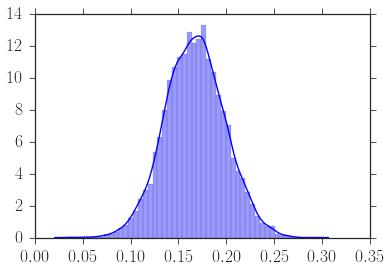

In [87]:
sns.distplot(slope_fit)

In [88]:
mean_slope = slope_fit.mean()
slope_error = slope_fit.std()
print mean_slope, '+-', slope_error

0.167296021993 +- 0.0311048782169


This gives us a reasonable estimate in the error of our fit.

# Measuring the slope with pymc3

We could also use a monte-carlo technique to estimate the slope, although I prefer bootstrapping in this case. Pymc3 is ideal for this.

In [110]:
import pymc3 as mc

In [113]:
def fit_data(input_data, num_steps=.5*10**5, tune=10**4): # Pass in the mean data of the desired key
        
    x = input_data['log_R_div_Ro'].values
    y = input_data['theta_minus_theta_o', 'mean'].values
    yerr = input_data['theta_minus_theta_o', 'sem'].values

    basic_model = mc.Model()
    
    with basic_model:
        # We just have to do a simple linear regression,
        # delta_theta = param * log(R/Ro)

        # Define the parameters and the errors associated with them
        slope = mc.Uniform('slope', lower=0, upper=1.0)

        y_guess = slope*x

        y_obs = mc.Normal('y_obs', mu=y_guess, sd=yerr, observed=y)   
        
        start =  mc.find_MAP(fmin=sp.optimize.fmin_powell)
    
        step = mc.NUTS()

        trace = mc.sample(num_steps, step, start=start, tune=tune)
        
    return trace

### Fitting black

In [114]:
fit = fit_data(mean_data)

 [-----------------100%-----------------] 50000 of 50000 complete in 7.3 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a76880650>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4a766f1c50>]], dtype=object)

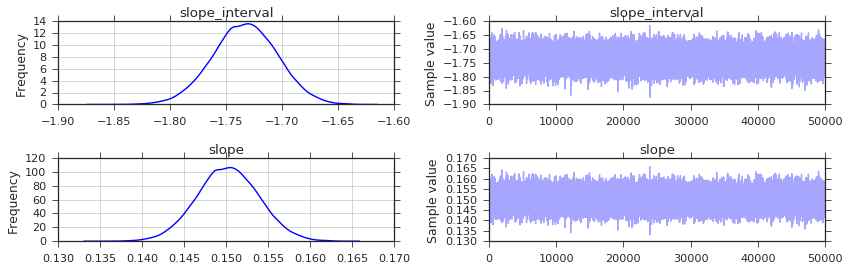

In [117]:
plt.rc('text', usetex=False) # Somehow, pymc3 screws up when using tex to render the plots.
sns.set_context('paper', font_scale=1.4)
mc.traceplot(fit)

In [118]:
mc.summary(fit)


slope_interval:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -1.733           0.029            0.000            [-1.790, -1.676]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.790         -1.752         -1.733         -1.713         -1.677


slope:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.150            0.004            0.000            [0.143, 0.157]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.143          0.148          0.150          0.153          0.157



Bootstrapping predicts a much larger error (by almost a factor of 10) and is likely more true to my experimental data.